In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

import matplotlib.pyplot as plt
import torch.optim as optim
import tqdm as tq

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
n=100
training_examples=50000
cv_examples=5000
testing_examples=5000

class Net_NHL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,1)
  
  def forward(self, X):
    return self.fc(X)

class Net_1HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=self.fc1(Op_1)
    return Op_2

class Net_2HL(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Linear(n+1,n//2)
    self.fc1=nn.Linear(n//2,n//4)
    self.fc2=nn.Linear(n//4,1)
  
  def forward(self, X):
    Op_1=F.relu(self.fc(X))
    Op_2=F.relu(self.fc1(Op_1))
    Op_3=self.fc2(Op_2)
    return Op_3


In [3]:
def generate_dataset(examples,n,_type):
  if(_type=='uniform'):
    train = np.random.rand(examples,n)
  elif(_type=='normal'):
    train = np.random.normal(loc=0,scale=1,size=(examples,n))
  elif(_type=='exponential'):
    train=np.random.exponential(scale=np.random.randint(1,5),size=(examples,n))
  
  train.sort()
  search = np.random.randint(0,n,examples)
  val = train[np.arange(len(train)), search]
  final_train= np.c_[train,val]
  final_train=final_train.astype("float32")
  mini=np.amin(final_train,axis = 1).reshape(examples,1)
  maxi=np.amax(final_train,axis = 1).reshape(examples,1)
  final_train=(final_train-mini)/(maxi-mini)

  final_train_ans=search/n
  final_train_ans=final_train_ans.astype("float32")

  train_input= torch.from_numpy(final_train)
  train_ans = torch.from_numpy(final_train_ans)
  train_input = train_input.to('cuda')
  train_ans = train_ans.to('cuda')


  return train_input,train_ans

def train_dataset(net,train_input,train_ans,cv_input,cv_ans,examples,lr=1e-2,batch_size=5000,epochs=1000):
  optimizer = optim.Adam(net.parameters(),lr =lr)
  train_loss = []
  cv_loss = []

  for e in tq.tqdm(range(epochs)):
    epoch_loss = 0
    for b in range(int(examples/batch_size)):
      
      x = train_input[b*batch_size:(b+1)*batch_size]
      y = train_ans[b*batch_size:(b+1)*batch_size]
      out = net(x.view(-1,n+1))
      loss= F.mse_loss(out.view(-1),y)
      epoch_loss += loss.item()
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    epoch_loss = epoch_loss/int(examples/batch_size)
    train_loss.append(epoch_loss)  
    print(epoch_loss)

    out = net(cv_input.view(-1,n+1))
    loss= F.mse_loss(out.view(-1),cv_ans)
    cv_loss.append(loss.item())

  plt.plot(np.arange(epochs),train_loss,label = 'Train')
  plt.plot(np.arange(epochs),cv_loss,label = 'Cross Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Average Epoch MSE Loss')
  plt.legend()
  plt.title('Loss vs Epochs')
  plt.show()


In [4]:
def binary_search(arr, l, r,x,cnt=0):
  # arr = list(arr)
  if r >= l:
        mid = l + int(np.floor((r - l)/ 2))
        if arr[mid] == x:
            return mid,cnt+1
        elif arr[mid] > x:
            return binary_search(arr, l, mid-1, x,cnt+1)
        else:
            return binary_search(arr, mid + 1, r, x,cnt+1)
  else:
        return r,cnt

def predict(net,test_input,n):
  out=net(test_input.view(-1,n+1))
  out=out*n
  return out

def get_predictions(test_input,n,examples,out):
  predictions_cnt = []
  bs_cnt = []
  for i in range(examples):
    bs_cnt.append(binary_search(test_input[i],0,n-1,test_input[i][n])[1])
    idx = int(out[i]) #predicted index
    if(idx>=n):
      idx = n-1
    if(idx<0):
      idx = 0
    
    if(test_input[i][idx] > test_input[i][n]):
      sub = 2
      cnt = 1
      while idx-sub >= 0:
        cnt+=1
        if(test_input[i][idx-sub] < test_input[i][n]):
          break;
        sub*= 2
      left = max(idx-sub,0)
      right = idx-(sub//2)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
      
    elif (test_input[i][idx] < test_input[i][n]):
      sub = 2
      cnt = 1
      while idx+sub <= n-1:
        cnt+=1
        if(test_input[i][idx+sub] > test_input[i][n]):
          break;
        sub*= 2
      left = idx+(sub//2)
      right = min(idx+sub,n-1)
      predictions_cnt.append(binary_search(test_input[i],left,right,test_input[i][n],cnt)[1])
    else:
      predictions_cnt.append(1)
    
  return predictions_cnt,bs_cnt

In [5]:
def test_single_array(net,n,_type):
  np.random.seed(64)
  if(_type=='normal'):
    testing = np.random.normal(loc=0,scale=1,size=n)
  elif(_type=='uniform'):
    testing = np.random.rand(n)
  elif(_type=='exponential'):
    testing=np.random.exponential(scale=np.random.randint(1,5),size=n)

  testing.sort()
  testing=(testing-testing[0])/(testing[n-1]-testing[0])
  
  L=[]
  for i in range(n):
    test_val = testing[i]
    test = np.append(testing,test_val)
    test = test.astype('float32')
    test_input = torch.from_numpy(test)
    test_input = test_input.to("cuda")
    out = net(test_input.view(-1, n+1))
    L.append(out.item()*n)
  
  plt.scatter(np.arange(n),testing)
  plt.title('Test Array')
  plt.xlabel('Index')
  plt.ylabel('Test Array Value')
  plt.show()
  plt.scatter(np.arange(n),L)
  plt.title('Predicted Index for each element')
  plt.xlabel('Index')
  plt.ylabel('Predicted Index')
  plt.show()
    

In [6]:
def generate_plots(predictions_cnt,bs_cnt):
  unique1, counts1 = np.unique(predictions_cnt, return_counts=True)
  d1  = dict(zip(unique1, counts1))
  unique2, counts2 = np.unique(bs_cnt, return_counts=True)
  d2  = dict(zip(unique2, counts2))
  plt.plot(list(d1.keys()),list(d1.values()),label = 'Predictor')
  plt.plot(list(d2.keys()),list(d2.values()),label = 'Binary Search')
  plt.xlabel('Number of Array Lookups(Steps)')
  plt.ylabel('Count of Test Inputs')
  plt.legend()
  plt.show()

  return d1,d2

def average_steps(d1,d2):
  print('Average Number of Steps')
  s=0
  for i in d1:
    s+=d1[i]*i
  print('Through Predictor:'+str(s/testing_examples))
  s=0
  for i in d2:
    s+=d2[i]*i
  print('Through Binary Search:'+str(s/testing_examples))


#Uniform


 43%|████▎     | 13/30 [00:00<00:00, 62.82it/s]

0.3367996044456959
0.14830588549375534
0.10429553687572479
0.07822203412652015
0.06678804866969586
0.05818675346672535
0.05068902298808098
0.04438944719731808
0.03857474066317081
0.03328755609691143
0.028563741222023965
0.024372290074825286
0.020684202387928962
0.017465503327548502
0.01467971559613943
0.012288811709731817
0.01025373926386237
0.008535425458103419
0.007095852680504322
0.005898927897214889
0.004911099746823311
0.004101777309551835
0.0034435012610629203
0.002911950834095478


100%|██████████| 30/30 [00:00<00:00, 76.68it/s]


0.0024858071468770505
0.0021465386729687453
0.001878206233959645
0.0016672695172019302
0.0015023724175989629
0.0013741251663304866


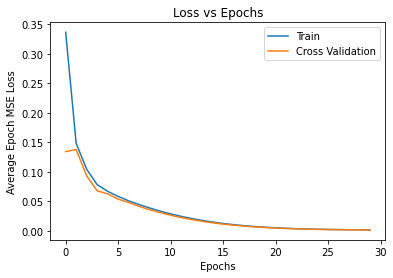

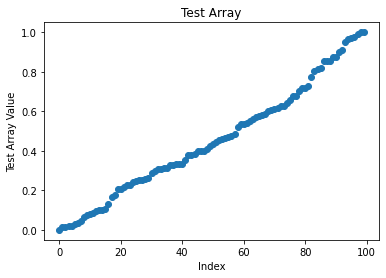

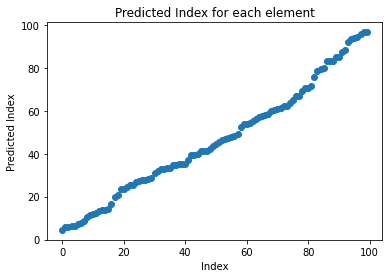

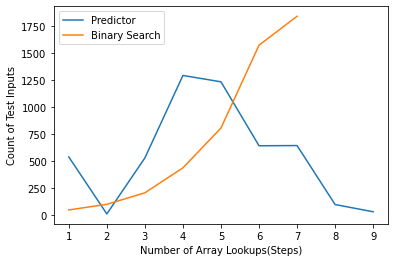

Average Number of Steps
Through Predictor:4.5604
Through Binary Search:5.791


In [7]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=30)
test_single_array(net,n,'uniform')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)



 60%|██████    | 12/20 [00:00<00:00, 60.99it/s]

0.15951012447476387
0.08692095801234245
0.07248419746756554
0.06404758170247078
0.05366730280220509
0.039772241935133935
0.02293539568781853
0.008879493316635489
0.002225730021018535
0.001185778493527323
0.0012062680558301508
0.0010401305102277548
0.0009721163718495518
0.0009399378206580878
0.0009214670630171895


100%|██████████| 20/20 [00:00<00:00, 63.24it/s]


0.0009121807001065463
0.0009023241233080626
0.0008972241426818073
0.0008941247244365514
0.000893980753608048


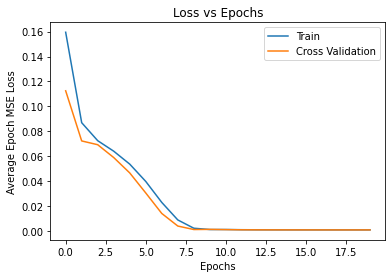

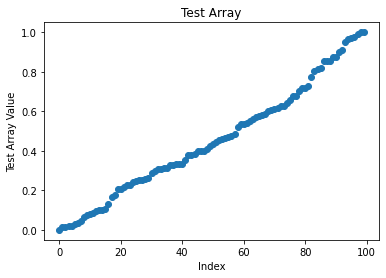

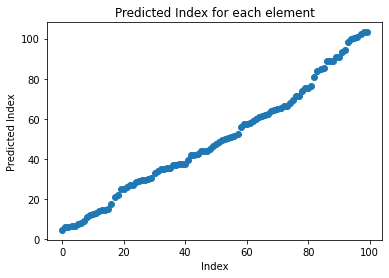

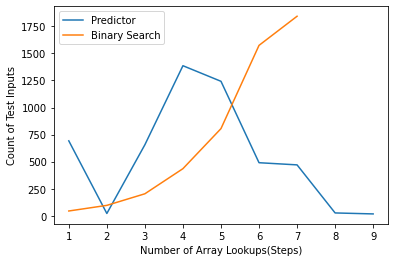

Average Number of Steps
Through Predictor:4.2094
Through Binary Search:5.791


In [8]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=20)
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_input,out=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

 30%|███       | 6/20 [00:00<00:00, 51.07it/s]

0.1029836006462574
0.08051741868257523
0.07261494398117066
0.05545496717095375
0.02615436799824238
0.00963464316446334
0.004905969079118222
0.002321192226372659
0.001432277332060039
0.001114230405073613
0.0009830841911025346


100%|██████████| 20/20 [00:00<00:00, 50.55it/s]

0.0009018554294016213
0.0008720365760382265
0.0008561209542676806
0.0008454133290797472
0.0008357316837646067
0.000825109367724508
0.0008128438901621848
0.0008015656843781471
0.0007936759444419295


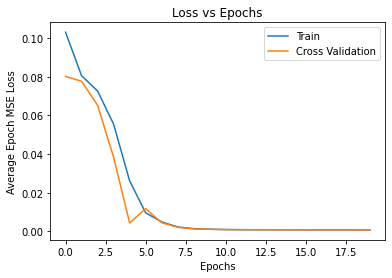

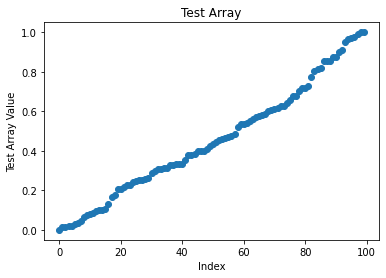

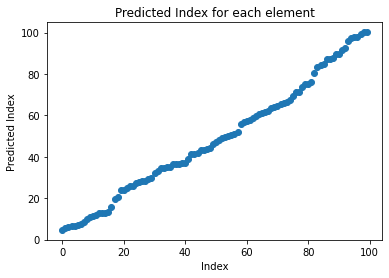

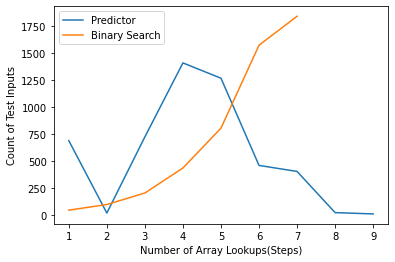

Average Number of Steps
Through Predictor:4.1398
Through Binary Search:5.791


In [9]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='uniform')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='uniform')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=20)
test_single_array(net_2,n,'uniform')

np.random.seed(42)
test_input,out=generate_dataset(testing_examples,n,_type='uniform')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Normal


 50%|█████     | 25/50 [00:00<00:00, 121.41it/s]

0.10514195784926414
0.07698591202497482
0.06646212823688984
0.05898728109896183
0.05238315984606743
0.04619691409170627
0.040952608734369275
0.03627320826053619
0.03196830805391073
0.02814240101724863
0.024731388688087462
0.021723920293152333
0.019087115488946437
0.016799687407910824
0.01482434757053852
0.013133854791522025
0.011697134282439948
0.010483979899436235
0.009466805309057236
0.008619779162108899
0.007919031335040927
0.00734296515583992
0.006872305693104863
0.0064900241326540705
0.006181227089837193


100%|██████████| 50/50 [00:00<00:00, 119.49it/s]

0.0059330141171813015
0.0057343027088791135
0.005575655726715922
0.005449148500338197
0.005348258651793003
0.005267760483548045
0.005203549424186349
0.005152376182377338
0.005111566791310906
0.0050788101274520155
0.005052157118916512
0.005030146054923535
0.0050117624923586845
0.0049962267279624935
0.004982885578647256
0.0049712466541677715
0.004960959684103728
0.004951748577877879
0.004943402810022235
0.004935771599411965
0.004928735736757517
0.004922208236530423
0.004916123393923044
0.004910429939627647
0.0049050900153815745


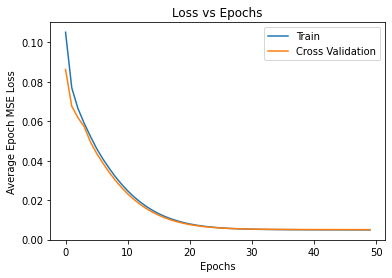

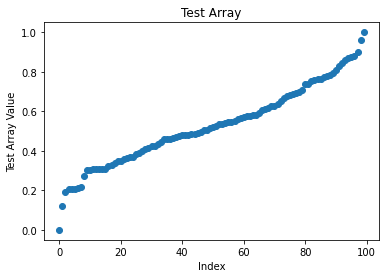

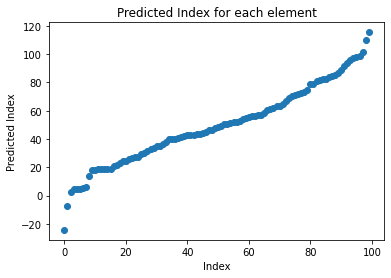

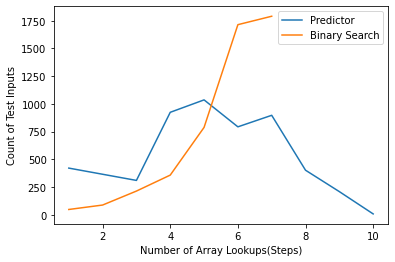

Average Number of Steps
Through Predictor:5.2882
Through Binary Search:5.8104


In [10]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

 16%|█▌        | 8/50 [00:00<00:00, 72.06it/s]

0.13136343881487847
0.08855573758482933
0.07961462065577507
0.0748420499265194
0.06962871551513672
0.06316945664584636
0.054704009741544726
0.04403279200196266
0.03201966993510723
0.020450167916715146
0.011522281263023616
0.00656235390342772
0.004730050638318062
0.004259588057175278
0.004753641085699201


 46%|████▌     | 23/50 [00:00<00:00, 67.52it/s]

0.0062385772354900835
0.004648825945332646
0.0042213423177599905
0.004027977609075606
0.003922339784912765
0.0038571428507566453
0.003747184737585485
0.003649041405878961
0.004445987148210406
0.003784819087013602
0.0037016491638496517
0.005719142034649849
0.004325268953107297
0.0037857430754229425


 76%|███████▌  | 38/50 [00:00<00:00, 69.66it/s]

0.0037786921486258505
0.003604492312297225
0.003704679477959871
0.00389068687800318
0.004655192862264812
0.0037225691601634027
0.004189553600735962
0.003543815645389259
0.004137669247575105
0.0043293322203680875
0.0036416249349713326
0.00417380016297102
0.00351875489577651
0.004237671452574432
0.004166970960795879


100%|██████████| 50/50 [00:00<00:00, 69.58it/s]


0.0035981055814772846
0.00420758321415633
0.0035058923764154314
0.004069015639834106
0.004303660639561713
0.0036062330938875673


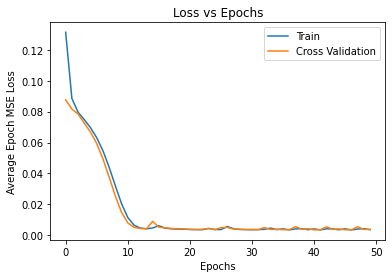

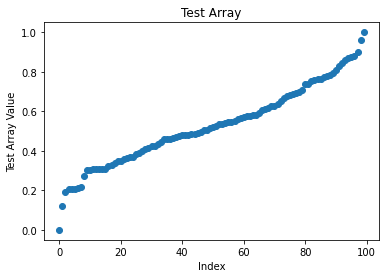

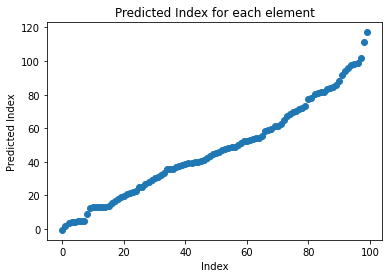

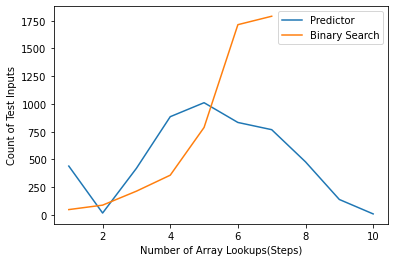

Average Number of Steps
Through Predictor:5.1736
Through Binary Search:5.8104


In [11]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_1,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

 12%|█▏        | 6/50 [00:00<00:00, 55.74it/s]

0.1306762471795082
0.08666571155190468
0.08061545193195344
0.07624125704169274
0.07064161822199821
0.06192421168088913
0.04630483090877533
0.026080340147018433
0.01512614283710718
0.0077314591500908135
0.005450036330148578


 36%|███▌      | 18/50 [00:00<00:00, 53.70it/s]

0.004285608674399555
0.003930014208890498
0.003756139730103314
0.003712973673827946
0.003683566558174789
0.0036582405446097255
0.0036724650301039217
0.003705789381638169
0.004436857718974352
0.0035941150272265077
0.0036364229628816245


 60%|██████    | 30/50 [00:00<00:00, 52.39it/s]

0.007618979760445654
0.004253863543272019
0.0037929125130176542
0.0035401172703132034
0.00337487212382257
0.0032107357401400805
0.0030595128191635013
0.0028869168600067496
0.003213326004333794
0.0032320384867489337
0.003679047618061304


 84%|████████▍ | 42/50 [00:00<00:00, 52.44it/s]

0.0028023771941661836
0.003694455511868
0.0028014631709083913
0.008364211511798203
0.00715207913890481
0.0037482234882190825
0.0023291545221582055
0.0018286321661435067
0.0016192748094908892
0.0014735326985828578
0.0013593872427009046


100%|██████████| 50/50 [00:00<00:00, 52.44it/s]


0.0012847743113525213
0.0012314307619817554
0.0011905243271030485
0.0011594367562793196
0.0011261931387707591
0.0010749312699772418


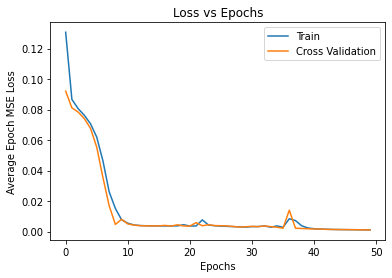

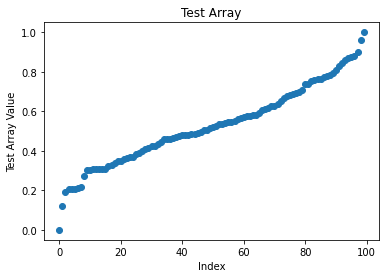

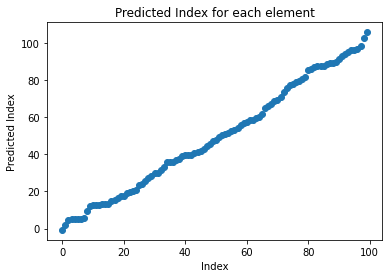

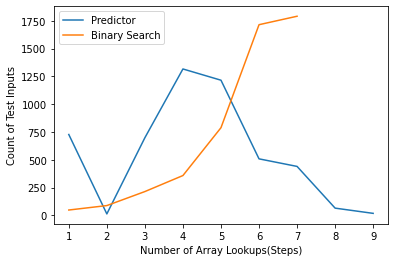

Average Number of Steps
Through Predictor:4.1992
Through Binary Search:5.8104


In [12]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='normal')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='normal')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_2,n,'normal')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='normal')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Exponential


 13%|█▎        | 13/100 [00:00<00:00, 121.65it/s]

0.15878430157899856
0.09629012793302535
0.08033365309238434
0.07101398929953576
0.06239926964044571
0.055871343985199926
0.05032725483179092
0.04532185010612011
0.04108025096356869
0.03746186792850494
0.03433510772883892
0.031687486730515954
0.029480789229273795
0.027656982839107513
0.0261597890406847
0.024940727278590202
0.02395725566893816
0.023171094432473182
0.02254809346050024
0.022058409079909323
0.021676461026072503
0.021380676701664925
0.021153104864060877
0.02097899429500103


 39%|███▉      | 39/100 [00:00<00:00, 120.29it/s]

0.02084637023508549
0.020745623484253885
0.020669142715632915
0.020610970631241798
0.020566506870090963
0.02053226288408041
0.020505637302994727
0.02048473320901394
0.02046818807721138
0.020455022901296617
0.0204445106908679
0.020436080545186995
0.020429263077676296
0.020423663966357707
0.020418965630233286
0.02041492648422718
0.020411380380392075
0.02040822319686413
0.020405386202037336
0.02040282152593136
0.020400485955178738
0.02039834316819906
0.02039636392146349
0.0203945267945528
0.02039281614124775


 64%|██████▍   | 64/100 [00:00<00:00, 118.13it/s]

0.020391216874122618
0.020389716513454913
0.020388304628431796
0.02038697209209204
0.02038571275770664
0.020384518057107927
0.02038338277488947
0.02038230299949646
0.020381272211670874
0.020380289107561112
0.02037934958934784
0.020378448627889158
0.020377586036920546
0.020376757718622684
0.020375963300466537
0.020375199243426324
0.02037446554750204
0.020373760908842086
0.02037308141589165
0.020372429490089418
0.0203718027099967
0.02037119958549738
0.020370620489120483
0.020370064489543437
0.02036953140050173


 90%|█████████ | 90/100 [00:00<00:00, 122.24it/s]

0.020369020104408265
0.02036853227764368
0.020368064753711224
0.020367620326578618
0.020367196574807168
0.02036679517477751
0.020366415567696094
0.020366057753562927
0.02036572266370058
0.02036540936678648
0.020365118607878686
0.02036485243588686
0.020364608243107797
0.02036439049988985
0.020364195667207242
0.020364026725292205
0.020363884419202803
0.02036376968026161
0.020363681577146055
0.020363623090088368
0.020363594219088555
0.020363596826791765
0.020363631844520568
0.020363700576126575
0.020363803021609783


100%|██████████| 100/100 [00:00<00:00, 119.66it/s]


0.020363943465054036


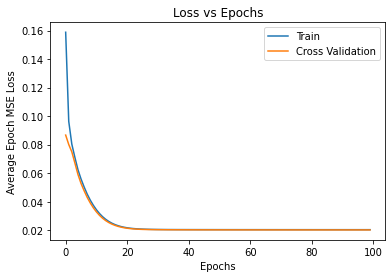

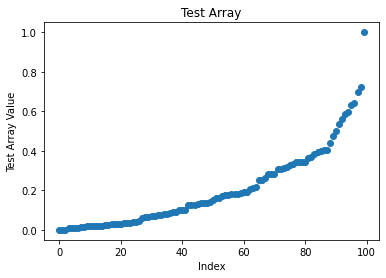

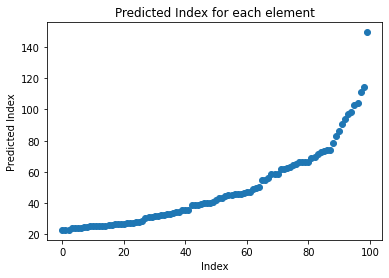

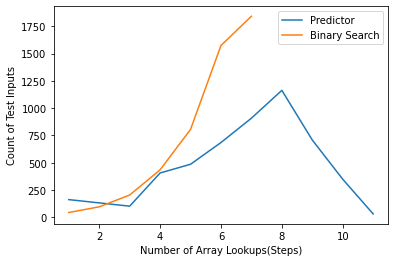

Average Number of Steps
Through Predictor:6.899
Through Binary Search:5.7902


In [13]:
net=Net_NHL()
net.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=100)
test_single_array(net,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  2%|▏         | 12/500 [00:00<00:08, 55.17it/s]

0.10295072644948959
0.07461279854178429
0.06085952632129192
0.04378808774054051
0.027659567818045617
0.021294617652893068
0.021349977888166904
0.02090570516884327
0.020630686730146407
0.02069978155195713
0.020727019198238848
0.020630796253681184


  4%|▎         | 18/500 [00:00<00:09, 51.34it/s]

0.020535188540816308
0.020552665181457996
0.02044700030237436
0.020273628085851668
0.019840711168944834
0.019122295081615448
0.01801841948181391
0.016638527065515517
0.01477745696902275
0.01244998760521412
0.010781160648912191


  6%|▌         | 30/500 [00:00<00:08, 53.67it/s]

0.009416258474811912
0.007881408138200641
0.00670215105637908
0.0058929158840328455
0.005024041375145316
0.004471725248731673
0.003754428820684552
0.005887410789728165
0.006011019251309336
0.0037996693048626185
0.003322070767171681
0.0031127071008086203


  8%|▊         | 42/500 [00:00<00:08, 53.80it/s]

0.0029880187241360543
0.002986608957871795
0.0029536602552980183
0.002754195430316031
0.0023957691621035336
0.0027866856195032596
0.0031932662706822155
0.002368990029208362
0.002977362391538918
0.002451068046502769
0.002981514041312039


 11%|█         | 54/500 [00:01<00:08, 50.77it/s]

0.0026028698310256006
0.002226133469957858
0.0022271866211667655
0.001943529222626239
0.00471660471521318
0.003498778201173991
0.00288694720948115
0.002468835434410721
0.002344889915548265
0.0022802416584454476

 13%|█▎        | 66/500 [00:01<00:08, 50.13it/s]


0.0022801515995524825
0.0022869824897497892
0.0022929409286007287
0.0022625078912824393
0.002192760119214654
0.0020741192158311604
0.0019208736717700957
0.0017577034886926413
0.0016741225961595773
0.0016589044826105237


 14%|█▍        | 72/500 [00:01<00:08, 49.90it/s]

0.0017444167868234217
0.0028523229295387862
0.0021763163385912776
0.001899308932479471
0.0016873984830453991
0.0015798460808582604
0.0015464293770492076
0.005110173695720732
0.003141272906213999
0.002468545630108565


 17%|█▋        | 84/500 [00:01<00:08, 51.59it/s]

0.0018976937280967832
0.0016883302596397698
0.0016706767259165646
0.001757163694128394
0.0017798818065784872
0.0017120109871029854
0.0015557929989881813
0.001418402837589383
0.0013896585558541119
0.001391038834117353


 18%|█▊        | 90/500 [00:01<00:09, 43.33it/s]

0.0014840439544059336
0.002366381441242993
0.0016945357318036258
0.0014468474430032075
0.001722376758698374
0.0020932041225023568
0.0019892191397957505


 20%|██        | 100/500 [00:02<00:10, 37.84it/s]

0.0014505803235806524
0.0013776280335150658
0.001247055595740676
0.0017786512966267765
0.00345744991209358
0.001874215085990727
0.0015445375349372626


 22%|██▏       | 110/500 [00:02<00:09, 40.37it/s]

0.001418363128323108
0.001222100481390953
0.0012124544940888883
0.0012206893181428314
0.0017005610163323582
0.0016081266454420983
0.001752635173033923
0.00165130136301741
0.0018011113977991044
0.0014219816075637937


 23%|██▎       | 115/500 [00:02<00:09, 41.69it/s]

0.0012756752315908671
0.0012336263549514114
0.0011963205528445543
0.0027160704834386707
0.001809729088563472
0.001474752218928188
0.0012619110406376422
0.0011902075377292932
0.0011632212554104626


 25%|██▌       | 125/500 [00:02<00:09, 41.16it/s]

0.0011026357184164225
0.0010880003916099667
0.0029831518651917575
0.0017358655110001563
0.0020811087568290533
0.0014135404955595732
0.0011829372262582183
0.0010419454774819314
0.0010471606743521988


 27%|██▋       | 136/500 [00:02<00:07, 45.87it/s]

0.0010105814726557583
0.0010228911123704165
0.0011439288617111742
0.0023708221153356133
0.0016398128704167903
0.0011952471220865845
0.00115769004332833
0.0010331905679777265
0.001060279639204964
0.0010645458358339965
0.002031888044439256


 29%|██▉       | 146/500 [00:03<00:07, 46.83it/s]

0.0015963254729285837
0.0010215640882961451
0.0010307083837687969
0.0011036858602892607
0.0021519612637348473
0.001173662848304957
0.0012055346451234072
0.000978297379333526
0.0012919151573441922
0.0011633377405814826
0.0017707547463942318


 32%|███▏      | 158/500 [00:03<00:06, 51.48it/s]

0.0016332672326825558
0.0012234308756887912
0.0009932236862368882
0.0010041422268841417
0.0009976680215913803
0.001466828549746424
0.001216721464879811
0.0015658787102438509
0.0012068028445355594
0.0010763127123937012
0.0009106768935453147
0.0009047717321664095


 34%|███▍      | 170/500 [00:03<00:06, 53.63it/s]

0.0008994957548566163
0.0010916946223005653
0.006400052504613995
0.0029955906677059828
0.001773133990354836
0.0010896829655393959
0.0010641526896506548
0.001025900075910613
0.0009586944652255625
0.0009499756095465272
0.0009931809443514794


 36%|███▋      | 182/500 [00:03<00:06, 48.94it/s]

0.0010612975398544221
0.0011333920992910862
0.0011921605502720923
0.001229320192942396
0.0012405221292283385
0.0012311684025917203
0.0012111831922084094
0.0011856092605739832
0.0011579719721339643
0.0011273214709945022


 38%|███▊      | 192/500 [00:04<00:06, 45.22it/s]

0.0010873627848923205
0.0010380296676885336
0.0009806124959141015
0.0009228409035131335
0.0008881499990820885
0.0008762139186728746
0.0008680684433784336
0.0008613745158072561
0.0008620109525509179


 40%|███▉      | 198/500 [00:04<00:06, 47.68it/s]

0.0009100128780119121
0.0013336674950551243
0.0013061909237876534
0.0012534325127489866
0.0009866563545074315
0.0010663279390428215
0.0008554300293326378
0.0008421671285759657
0.0012183241255115719
0.003057228249963373


 42%|████▏     | 209/500 [00:04<00:05, 48.51it/s]

0.0018335172440856694
0.001258727366803214
0.0009239891543984414
0.0008638520899694413
0.0008745339524466545
0.0008636877697426826
0.0008424355532042682
0.0008430411980953068
0.0008531830098945647
0.0009252560848835856
0.0014958344458136708


 44%|████▍     | 219/500 [00:04<00:06, 42.72it/s]

0.0010928617441095412
0.0014821573859080672
0.0012064397102221846
0.0008498471172060818
0.0008606571878772229
0.000947453617118299
0.0015064905397593974


 46%|████▌     | 229/500 [00:04<00:06, 44.57it/s]

0.0009124990203417838
0.0014376414939761162
0.001252157852286473
0.0009972363070119173
0.0009910132910590618
0.0009696601133327931
0.001176390249747783
0.0008275543223135173
0.0008213504566811025
0.0014131964882835746


 47%|████▋     | 234/500 [00:05<00:06, 41.02it/s]

0.0030755166662856936
0.00177565444028005
0.0013883152976632118
0.0011362787918187678
0.0010290898208040744
0.0009677775728050619
0.0009181095170788467


 49%|████▉     | 245/500 [00:05<00:06, 41.95it/s]

0.000863994681276381
0.0008369896793738007
0.0008285793825052679
0.0008235852175857872
0.0008245723904110492
0.0008451096015051007
0.0010671817697584629
0.0014392513199709355
0.0009266013512387872
0.0010692711861338467


 51%|█████     | 256/500 [00:05<00:05, 42.81it/s]

0.0011192631849553437
0.0014579073351342231
0.0011791210912633688
0.0010632411285769194
0.0008215465932153165
0.0008207173552364111
0.0010021131834946572
0.0017676724586635829
0.0010406242741737514


 52%|█████▏    | 261/500 [00:05<00:06, 38.77it/s]

0.0008615946571808308
0.000912275561131537
0.0010783610050566494
0.0012306624150369317
0.0008044695423450321
0.0008533004380296916
0.0012870792532339692
0.002032430795952678
0.0013685991521924733


 54%|█████▍    | 272/500 [00:05<00:05, 44.08it/s]

0.0010231999098323286
0.0008389849914237857
0.0008374075521714985
0.0009000491525512188
0.0009586294705513865
0.0011660631978884339
0.001133737072814256
0.0007942831318359822
0.0008175548398867249
0.0021913781529292464
0.0016793783695902675


 56%|█████▋    | 282/500 [00:06<00:05, 41.83it/s]

0.0012986943125724792
0.0009465702518355101
0.0008260836068075151
0.0008427220163866878
0.0008188317995518446
0.0008110702794510872
0.000978359265718609
0.0016906900156755


 57%|█████▋    | 287/500 [00:06<00:05, 39.38it/s]

0.0009842010098509491
0.000895550474524498
0.0010462170757818967
0.0010993209260050207
0.0008247649413533509
0.0009233155171386898
0.001186515693552792


 59%|█████▉    | 296/500 [00:06<00:05, 37.53it/s]

0.001485482434509322
0.0017209854908287526
0.0010284171614330262
0.0009272921481169761
0.0007963880547322333
0.0008166170970071107
0.001018902042414993
0.0012297502369619906


 61%|██████    | 306/500 [00:06<00:04, 40.24it/s]

0.0007889578875619919
0.0007962916104588657
0.0014492832589894534
0.0025815466069616377
0.001556910580256954
0.001164802088169381
0.0008839379297569394
0.0008048317569773645
0.0008163166290614754


 63%|██████▎   | 315/500 [00:07<00:04, 37.18it/s]

0.0008097910496871919
0.0008066947746556252
0.0008106543973553926
0.0009364069963339716
0.0013315662974491716
0.0008172113099135459
0.0009073195746168494


 64%|██████▍   | 319/500 [00:07<00:05, 31.55it/s]

0.0008905291324481368
0.000954282161546871
0.001966040476690978
0.0016274579509627074
0.0008681247127242386
0.000928938965080306
0.0008146239153575153
0.0009080376941710711


 66%|██████▌   | 328/500 [00:07<00:05, 31.61it/s]

0.0008510083483997732
0.0010306327661965043
0.0015070739318616688
0.0009652825887314975
0.0008416433760430664
0.00112544204457663


 67%|██████▋   | 336/500 [00:07<00:05, 31.17it/s]

0.0010937821818515659
0.0008573521103244275
0.0008719623205251992
0.0007949773746076972
0.0018098198634106666
0.0024858390679582953
0.0017590472707524896


 69%|██████▉   | 345/500 [00:08<00:04, 36.02it/s]

0.0013532258628401906
0.001217616396024823
0.001127201586496085
0.0010634930920787155
0.0010271661507431419
0.0009784219379071145
0.0009259022306650877
0.0008652384334709495
0.0008147636079229414


 71%|███████   | 354/500 [00:08<00:03, 37.96it/s]

0.0008012616017367691
0.0008011907339096069
0.0007972441089805216
0.0008113469288218766
0.0008879520872142165
0.0011359505995642393
0.0009494237776380033
0.0008085310168098658
0.0013941894168965519


 72%|███████▏  | 358/500 [00:08<00:03, 36.25it/s]

0.0011756091262213886
0.0013474758539814501
0.0011193915037438274
0.0008373730350285768
0.000925474101677537
0.0007786141359247267
0.0008445557148661464


 73%|███████▎  | 366/500 [00:08<00:03, 33.82it/s]

0.001647055905777961
0.0009719137626234442
0.0011342409590724856
0.00116408285102807
0.0007876144198235124
0.0007982527720741927
0.0010646161274053157
0.0014155559765640646


 75%|███████▌  | 375/500 [00:08<00:03, 34.76it/s]

0.001072197110624984
0.001048683695262298
0.0008044998336117715
0.0008320943103171885
0.0008053659170400351
0.002052900765556842
0.0011777901789173483


 77%|███████▋  | 384/500 [00:09<00:03, 36.79it/s]

0.0009672619926277548
0.0007836417062208056
0.0008130946196615696
0.0010190588363911957
0.0009469963668379932
0.0009480285632889717
0.001452192448778078
0.000841573957586661


 78%|███████▊  | 392/500 [00:09<00:03, 35.44it/s]

0.0009896895731799304
0.0010322311718482524
0.0015694276487920433
0.0011292754265014083
0.001045715156942606
0.0008325471368152648
0.0009604397695511579
0.0008100824663415552


 80%|████████  | 402/500 [00:09<00:02, 41.42it/s]

0.0008028095646295697
0.0016156776109710336
0.0011240551131777466
0.0013120952935423702
0.0009983594878576695
0.0008339238585904241
0.0009252391406334937
0.0007816897355951369
0.0008988460409455002
0.001668456575134769


 82%|████████▏ | 412/500 [00:09<00:01, 44.05it/s]

0.000906210538232699
0.0008394921838771552
0.0010090451803989708
0.0010973183729220183
0.0007666161865927279
0.0008055890095420182
0.002033560798736289
0.00110739772208035
0.000901422102469951
0.0007820561004336923


 83%|████████▎ | 417/500 [00:09<00:01, 41.95it/s]

0.0007912024506367743
0.0011510511685628444
0.0010601240675896407
0.001004384784027934
0.00086309754406102
0.0015856494312174619
0.000995566917117685
0.0010403131833299994


 85%|████████▌ | 427/500 [00:10<00:01, 36.52it/s]

0.0010753985377959907
0.0007722205598838627
0.0007843248313292861
0.0011590680165681987
0.0016017466376069933
0.0012657270242925733
0.0009167424985207617


 86%|████████▋ | 432/500 [00:10<00:01, 39.40it/s]

0.0008655174868181347
0.0008530549239367247
0.000779128959402442
0.0009890832530800252
0.0013620858546346426
0.0008672883326653391
0.0008176936069503426
0.001176042837323621
0.0013823227141983806


 88%|████████▊ | 442/500 [00:10<00:01, 40.40it/s]

0.0011630959634203464
0.0010572620900347828
0.0007990245765540748
0.000930387550033629
0.0008612019009888172
0.0008747876563575119
0.0015755006228573621
0.0008743722748477012
0.0008969690185040236

 89%|████████▉ | 447/500 [00:10<00:01, 39.62it/s]


0.0010558126028627156
0.0011149483558256178
0.0009440632071346045
0.0008510865562129765
0.0014240463555324824
0.0008290157944429666


 91%|█████████ | 456/500 [00:10<00:01, 34.05it/s]

0.0009223232453223317
0.0010039499786216766
0.0014451855677179992
0.0010304327181074769
0.0010841546638403088
0.0007709312834776938
0.0007931506494060159


 93%|█████████▎| 466/500 [00:11<00:00, 39.27it/s]

0.0011706322955433279
0.0011013618437573313
0.0009860269725322723
0.0008654738892801106
0.0014359423192217946
0.0008322967390995472
0.0008528984908480197
0.0010427492612507193
0.0013196314685046673


 94%|█████████▍| 471/500 [00:11<00:00, 35.76it/s]

0.0009891685971524567
0.000994507025461644
0.0008784299832768738
0.0008087400754448026
0.0007853828486986458
0.0019435279013123364
0.0014332799182739109


 96%|█████████▌| 479/500 [00:11<00:00, 32.79it/s]

0.0011629731976427137
0.0008430442947428673
0.0008200485724955797
0.0007967453333549201
0.0008578826149459928
0.000859258056152612
0.001047416980145499
0.001182261254871264


 98%|█████████▊| 488/500 [00:11<00:00, 32.71it/s]

0.0007876079471316189
0.0007841925369575619
0.0013061520410701632
0.0018095612758770585
0.0013296125514898449
0.0007914237095974386


 98%|█████████▊| 492/500 [00:12<00:00, 31.17it/s]

0.0008302665140945464
0.0007869156892411411
0.0008614044811110944
0.000818730634637177
0.0010232765751425176
0.001259566395310685
0.0008585294708609581


100%|██████████| 500/500 [00:12<00:00, 40.75it/s]

0.0008049526542890817
0.0013208574266172946
0.0010344571550376714
0.00113461249275133
0.0011609287466853857


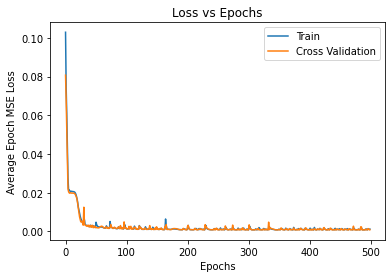

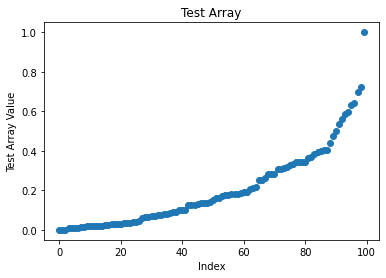

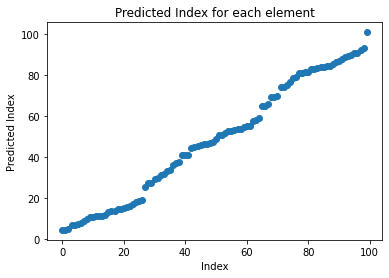

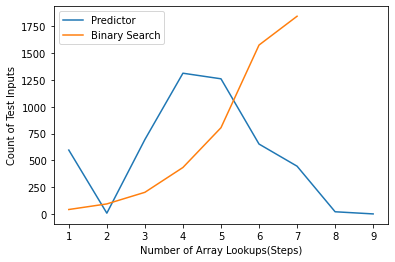

Average Number of Steps
Through Predictor:4.3016
Through Binary Search:5.7902


In [14]:
net_1=Net_1HL()
net_1.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=500)
test_single_array(net_1,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

  1%|          | 12/1000 [00:00<00:18, 53.91it/s]

0.13150757178664207
0.08329498097300529
0.07173674330115318
0.05784778967499733
0.03744938913732767
0.022843480482697485
0.021434023045003414
0.02026266735047102
0.01993030998855829
0.019555395282804967
0.01904260702431202
0.018721679970622063


  2%|▏         | 24/1000 [00:00<00:17, 54.40it/s]

0.01804780699312687
0.017050623148679733
0.01639069626107812
0.015281892288476229
0.012701480742543935
0.010842002835124731
0.00895186783745885
0.007124465424567461
0.00688002840615809
0.004533122270368039
0.0032562764128670095
0.002560613118112087


  4%|▎         | 36/1000 [00:00<00:17, 55.33it/s]

0.0021444216603413225
0.0018453542958013712
0.0015221219277009369
0.0014873926527798175
0.002185987995471805
0.0018909779144451022
0.0016092092148028315
0.0014067249256186187
0.0011588256456889212
0.0010440515121445059
0.0010230707004666329
0.0010637009865604341


  5%|▍         | 48/1000 [00:00<00:17, 55.32it/s]

0.001468910730909556
0.0011167827062308789
0.0014153001713566483
0.0012762507365550845
0.0010365446971263737
0.0011581667000427841
0.0009332675370387733
0.0014280874573159962
0.0014188020315486938
0.0009982502670027316
0.001079872390255332
0.000925874401582405


  6%|▌         | 60/1000 [00:01<00:16, 55.60it/s]

0.0011533394805155694
0.0012409507296979427
0.0010100332729052752
0.0011418992711696775
0.0010974173375871033
0.0008955347177106888
0.0008588757191319019
0.0009029612876474858
0.0022533034265507013
0.0017632141418289394
0.0015916439529974013
0.001516494422685355


  7%|▋         | 72/1000 [00:01<00:16, 54.95it/s]

0.001371690194355324
0.0011150763544719665
0.0009960184863302857
0.0009439154469873756
0.0009291870344895869
0.0009418777714017779
0.0009757135238032788
0.001025853940518573
0.0010841213283129037
0.0011463400616776199
0.0011945865757297725
0.0012062845460604876


  8%|▊         | 84/1000 [00:01<00:16, 54.81it/s]

0.001147534977644682
0.0010636733670253307
0.0010046323644928635
0.0009676279558334499
0.0009538045153021813
0.0009613093105144798
0.0009856986755039543
0.0010305505071301012
0.0010836891422513872
0.001144096883945167
0.0011706258286722005
0.0011437693377956749


 10%|▉         | 96/1000 [00:01<00:16, 56.16it/s]

0.0010652990080416203
0.000986888207262382
0.0009305564046371729
0.0009031926514580846
0.0009044132952112704
0.0009211182536091655
0.0009502185333985835
0.0009934011613950133
0.0010272895568050444
0.0010300740250386298
0.0010140479193069042
0.0009839670441579075


 11%|█         | 108/1000 [00:01<00:16, 55.66it/s]

0.0009425928117707371
0.0009017032571136951
0.0008742068894207478
0.0008606022922322154
0.0008454982889816165
0.0008279597852379084
0.0008155208663083613
0.0008007635304238647
0.0007886673847679049
0.000781570584513247
0.0007770229771267622
0.0007631080166902393


 12%|█▏        | 120/1000 [00:02<00:16, 54.91it/s]

0.0007434900908265263
0.0007083934033289552
0.0006649431772530079
0.0006225373304914683
0.0005937729147262871
0.0005787213041912765
0.0005778150749392808
0.0005703310715034604
0.0005736313061788679
0.0005998877226375043
0.0007627566927112639
0.000760235934285447


 13%|█▎        | 132/1000 [00:02<00:15, 55.10it/s]

0.0005666247743647546
0.0011473558144643903
0.0012931153818499298
0.0016445860033854841
0.0009713823557831347
0.0007767417468130588
0.0007259917736519128
0.0006947793066501617
0.0006657048827037216
0.0006115932832472026
0.0005649536848068238
0.0005404666182585061


 14%|█▍        | 144/1000 [00:02<00:15, 55.44it/s]

0.0005408383323810995
0.0005345348676200956
0.0005330849555321038
0.000544870289741084
0.0008309377415571361
0.0007248579349834472
0.0006917851394973695
0.0006396107783075422
0.0007941655989270657
0.0005996719119139016
0.0006644877255894243
0.0007009478751569987


 16%|█▌        | 156/1000 [00:02<00:15, 55.25it/s]

0.0008760840049944818
0.0006655063654761762
0.0006971779221203178
0.0006648080714512616
0.0005383908050134778
0.0005740812397561967
0.0009229197399690747
0.0006454274582210929
0.0009954736917279661
0.0006213598768226803
0.0005822144274134188
0.0006977447599638253


 17%|█▋        | 168/1000 [00:03<00:14, 55.82it/s]

0.0005525467393454164
0.0007106313307303936
0.0008079169143456966
0.0005107209784910083
0.0005740789754781872
0.0008502442098688335
0.0005873241287190467
0.0010957992752082645
0.0007490209769457579
0.0007938664173707366
0.0010130142618436366
0.001034812309080735


 18%|█▊        | 180/1000 [00:03<00:14, 54.94it/s]

0.0008150302921421826
0.0006688169145490974
0.0005864091566763818
0.0005207817011978477
0.0005022331606596708
0.0005036538845160976
0.000502354305353947
0.0004998056829208508
0.000584111426724121
0.0007757303945254534
0.0005122798029333353
0.0004930884810164571


 19%|█▊        | 186/1000 [00:03<00:15, 53.84it/s]

0.0009733542276080698
0.0008855638967361301
0.0007372198568191379
0.0006659049395238981
0.0007063911471050233
0.0007350528030656278
0.0006167406449094414
0.00058285916747991
0.0005147629475686699
0.0005499358230736107
0.0004922595951939001


 20%|█▉        | 198/1000 [00:03<00:14, 54.38it/s]

0.0004988650704035536
0.0009349369502160698
0.000682801433140412
0.0005662897718138992
0.0006338076142128557
0.0005451363656902685
0.0004799887334229425
0.000611681173904799
0.0010344156267819925
0.000708138570189476
0.0006330059230094775
0.000518744919099845


 21%|██        | 210/1000 [00:03<00:14, 54.54it/s]

0.0005157715873792768
0.0006071973592042923
0.0006450399174354971
0.0005544917716179043
0.0006914750905707478
0.0007209872012026608
0.0005057802802184597
0.0005434170365333557
0.0005540546088013798
0.0008211357868276537
0.0005692364647984505


 22%|██▏       | 222/1000 [00:04<00:14, 53.96it/s]

0.000878163066226989
0.0005691926402505487
0.0005466503760544583
0.0007049747160635889
0.000503299105912447
0.0005097206914797426
0.00047743952309247105
0.0004701203608419746
0.00132811936782673
0.0011867709807120263
0.0015122422948479653


 23%|██▎       | 234/1000 [00:04<00:14, 52.21it/s]

0.0007023543934337795
0.0005602056829957291
0.0005456783430418
0.0005478572682477533
0.0005187668983126059
0.00048560411087237296
0.0004638514219550416
0.0004621213854989037
0.00046036232670303433
0.0004595760809024796
0.00046166946995072065


 25%|██▍       | 246/1000 [00:04<00:14, 53.46it/s]

0.00048262368072755636
0.0006656443409156054
0.0006928986753337085
0.0005206666945014149
0.0006136903946753591
0.0004781599942361936
0.0007495432801079005
0.0006605046713957563
0.0006063857261324301
0.0005059375136625022
0.0007009248482063412
0.00047485488175880164


 26%|██▌       | 258/1000 [00:04<00:13, 54.79it/s]

0.0005878592492081225
0.0005983653012663126
0.00047677906695753336
0.0004753980989335105
0.0009795097401365637
0.000685072730993852
0.0006546774297021329
0.0005654040200170129
0.0005117718363180756
0.0005835830932483077
0.00046796099341008814
0.0004540358553640544


 27%|██▋       | 270/1000 [00:04<00:13, 55.53it/s]

0.0004541836242424324
0.000642097310628742
0.0016866773890797048
0.00138646176783368
0.0011824196873931215
0.0008230538864154368
0.0006114013260230422
0.0005226907669566572
0.0004925329849356785
0.0004878725070739165
0.000496975690475665
0.0004980526340659708


 28%|██▊       | 282/1000 [00:05<00:13, 54.31it/s]

0.0004754499706905335
0.00045300048077479005
0.0004461718926904723
0.00044934572360944003
0.00044797975569963453
0.00044883168884553016
0.00044934264151379465
0.0004505179007537663
0.0004619168234057724
0.0005676235916325823
0.0008248410653322935
0.0005230828770436347


 29%|██▉       | 294/1000 [00:05<00:13, 54.03it/s]

0.0005056943831732496
0.0005247135035460815
0.0005510377406608314
0.00047475050669163463
0.000514989226940088
0.00092030965606682
0.0005658992100507021
0.0005333059816621244
0.0006109207926783711
0.00048358372878283263
0.0005206062458455562
0.0004612873890437186


 31%|███       | 306/1000 [00:05<00:12, 54.83it/s]

0.0006269180856179446
0.0007199364743428304
0.0005963839590549469
0.00047008396650198846
0.0005076741246739403
0.0006492983433417976
0.0005433991114841774
0.000469153985613957
0.0006696338998153806
0.0005971472826786339
0.0006076995952753351
0.0006025427370332182


 32%|███▏      | 318/1000 [00:05<00:12, 54.80it/s]

0.0005039186624344438
0.0005313309433404356
0.0005376187240472063
0.0005448944924864918
0.0006590373755898327
0.00047472117585130037
0.0005253789480775594
0.0008451082860119641
0.0005591933557298034
0.0005099395144497976
0.0005342312098946423


 33%|███▎      | 330/1000 [00:06<00:12, 52.83it/s]

0.0005254804680589586
0.00045776660554111006
0.0004937495978083462
0.0009730044694151729
0.0006121102866018191
0.0005081422132207081
0.0005676901928381994
0.0004891453572781757
0.00048634117119945587
0.000444721698295325
0.0004556207917630672


 34%|███▎      | 336/1000 [00:06<00:12, 52.92it/s]

0.0008602875284850597
0.0007554060925031081
0.000638628687011078
0.0005887260573217646
0.0004943283973261714
0.0004716692812507972
0.00044667215552181007
0.0004597490333253518
0.0005340783827705309
0.0007374416862148791
0.0004980444762622937


 35%|███▍      | 348/1000 [00:06<00:12, 52.89it/s]

0.0006855792715214192
0.00047641918645240365
0.000563130941009149
0.00044618996907956897
0.0005024219455663115
0.0008121459221001714
0.0005225171102210879
0.0006412165792426094
0.0006043454195605591
0.0005186080641578882
0.00046298826928250494


 36%|███▌      | 360/1000 [00:06<00:11, 53.58it/s]

0.0004879557905951515
0.0005398661480285228
0.0005723665235564113
0.0006033367244526744
0.0004971937130903825
0.0004425157734658569
0.0004582146677421406
0.0009716782718896866
0.0006748297048034147
0.0005289856373565272
0.0005447530362289399
0.0004989595356164501


 37%|███▋      | 372/1000 [00:06<00:11, 55.01it/s]

0.000445656047668308
0.0004398794408189133
0.00048276034649461506
0.0007877124182414264
0.00047524352266918867
0.0006100770435296
0.00045710917038377374
0.0005443433590698987
0.0006466693943366408
0.0005247108318144455
0.000574141411925666
0.00046417547564487905


 38%|███▊      | 384/1000 [00:07<00:11, 55.53it/s]

0.0006126089137978852
0.0005082395306089893
0.0004374950978672132
0.0005579157586907968
0.0007734914193861187
0.0005518333608051762
0.0005020493554184213
0.0004489328450290486
0.0004541449074167758
0.00048713221040088686
0.0008552221814170479
0.0005354822293156758


 40%|███▉      | 396/1000 [00:07<00:10, 56.35it/s]

0.0006503557611722499
0.0005868169973837212
0.0005288283486152068
0.0004624494060408324
0.0004531098791630939
0.000473321697791107
0.0004849426855798811
0.0006983850384131074
0.0004469180654268712
0.0004425567225553095
0.0005740155145758763
0.0007198526262072846


 41%|████      | 408/1000 [00:07<00:10, 55.32it/s]

0.0005277074145851657
0.0005362167401472106
0.00043471711687743665
0.0004549033270450309
0.0005290808476274833
0.0007572664006147533
0.0004938420897815377
0.00059816537250299
0.0004626980342436582
0.00044428986439015716
0.00045757911284454166
0.0008010739868041128


 42%|████▏     | 420/1000 [00:07<00:10, 55.49it/s]

0.0004847603995585814
0.0005162358342204243
0.00047119685332290827
0.0004958872013958171
0.0006032177363522351
0.0004969343543052673
0.00043720523826777934
0.0005960840382613242
0.0006740686832927168
0.0005337003443855792
0.0004501276678638533
0.0004842979513341561


 43%|████▎     | 432/1000 [00:07<00:10, 54.82it/s]

0.0006192723056301474
0.00044720914447680114
0.0004220821865601465
0.0006139422679552808
0.0007373314292635769
0.0005675937456544489
0.0005001407087547704
0.0004206215060548857
0.0004195006302325055
0.0004214737971778959
0.0008055462356423959


 44%|████▍     | 444/1000 [00:08<00:10, 54.95it/s]

0.0006569533434230834
0.000535415014019236
0.000523781921947375
0.0004679468955146149
0.0004813998297322541
0.0004198471753625199
0.0004149300890276209
0.000626972210011445
0.0007284286053618416
0.0005722141620935872
0.0005400201975135132
0.00045864886487834156


 46%|████▌     | 456/1000 [00:08<00:09, 54.52it/s]

0.0004592479526763782
0.00044131329632364215
0.000427605674485676
0.0006385490240063518
0.0005917820264585317
0.0004910611954983324
0.0004220376809826121
0.00048274173168465494
0.000698682467918843
0.0004428304120665416
0.00045997076376806944


 47%|████▋     | 468/1000 [00:08<00:09, 54.56it/s]

0.000409078728989698
0.0004304653673898429
0.0009689664148027077
0.0005558996461331844
0.0004821533570066094
0.00041752004181034864
0.0004095468670129776
0.00044009853154420854
0.0006787246558815241
0.0004816211381694302
0.00043532198178581895


 48%|████▊     | 480/1000 [00:08<00:09, 54.61it/s]

0.0004146671475609764
0.0004011258017271757
0.0007162780122598634
0.0013639020500704647
0.0010767872707219794
0.0006763432960724458
0.00045862595434300604
0.0004185979720205069
0.0004224849602906033
0.00042414609051775185
0.0004183192824712023
0.0004091417766176164


 49%|████▉     | 492/1000 [00:09<00:09, 54.55it/s]

0.0004061070270836353
0.0004038900719024241
0.00040194854082074014
0.0004062695777975023
0.0004191791667835787
0.0004661192302592099
0.0005616340902633965
0.00045336879265960305
0.0004240869922796264
0.0005564373568631709
0.0005589698295807466


 50%|█████     | 504/1000 [00:09<00:09, 54.35it/s]

0.00040137888863682746
0.0004036863334476948
0.0006879472814034671
0.0006126807304099203
0.0005176052189199253
0.00053481679642573
0.00043797681573778393
0.0004673507937695831
0.0004614403267623857
0.00042370262090116737
0.0005988253949908539
0.000535569156636484


 51%|█████     | 510/1000 [00:09<00:09, 53.20it/s]

0.00041969689482357353
0.0003991444653365761
0.000587017650832422
0.000879876216640696
0.0006619951280299574
0.000455146620515734
0.00041982334514614197
0.00041232309595216063
0.000396614961209707
0.00045067596074659376
0.0005688817938789726


 52%|█████▏    | 522/1000 [00:09<00:08, 54.14it/s]

0.0004659687547245994
0.0004556684463750571
0.0006009342730976641
0.00041295377595815805
0.00039543536549899725
0.0006699620396830141
0.0008301834430312737
0.0006359186430927366
0.0004361377388704568
0.00041358230519108476
0.0003988394164480269
0.00039409529708791526


 53%|█████▎    | 534/1000 [00:09<00:08, 54.55it/s]

0.0004618080187356099
0.0005978182016406208
0.00042079826816916467
0.0004226228833431378
0.0006926005793502554
0.0004177881550276652
0.0004324084293330088
0.00040731287153903393
0.0007624689431395381
0.0004823785537155345
0.00046422939922194926


 55%|█████▍    | 546/1000 [00:10<00:08, 54.71it/s]

0.00048464752908330413
0.00042986436164937913
0.000448820082237944
0.0006994276016484946
0.000433748317300342
0.0004291618970455602
0.00047085219994187356
0.0006815428030677139
0.00046375465171877295
0.00040170124848373236
0.0005526752036530524
0.0004770292405737564


 56%|█████▌    | 558/1000 [00:10<00:08, 53.91it/s]

0.000419416805380024
0.0006430261069908738
0.0005048554914537818
0.0004470261570531875
0.00042513376101851465
0.0006285484443651513
0.00039944459276739506
0.0003868049680022523
0.0006390725437086075
0.0009158051718259231
0.00064786609436851
0.0004229306912748143


 57%|█████▋    | 570/1000 [00:10<00:07, 54.16it/s]

0.0004373831558041275
0.00040187848499044775
0.00041863548976834865
0.00038790224061813205
0.00046084614878054707
0.0006036980921635404
0.0003883995959768072
0.0003911998646799475
0.0007011948444414883
0.0005745646863942966
0.0004743604717077687


 58%|█████▊    | 582/1000 [00:10<00:07, 54.43it/s]

0.0005543543345993384
0.0004551766876829788
0.0005392399500124157
0.00042699323385022583
0.000464834930608049
0.0003893616783898324
0.0004188015125691891
0.0007267727225553245
0.0004153153829975054
0.00040643887768965214
0.00046243860269896687
0.0006486432102974504


 59%|█████▉    | 594/1000 [00:10<00:07, 54.60it/s]

0.0004159254633123055
0.000388873225892894
0.0005756472295615822
0.0005914835084695369
0.0004448517778655514
0.0004587283241562545
0.00045014102652203293
0.0003888120612828061
0.0006373393669491633
0.0007311543129617348
0.0005650057457387448
0.0005401196132879705


 61%|██████    | 606/1000 [00:11<00:07, 55.50it/s]

0.0004484409233555198
0.0004036782920593396
0.0003884234873112291
0.00043221601226832717
0.00040858672291506083
0.0005398455308750272
0.0005920690688071773
0.0004361573519418016
0.0004538096603937447
0.00046543191419914367
0.0003793099633185193
0.0005375902634114027


 62%|██████▏   | 618/1000 [00:11<00:06, 55.78it/s]

0.0008017663727514446
0.0005963823932688683
0.0005569237779127434
0.00044412747374735775
0.0003840896213660017
0.0003963073279010132
0.0003856872906908393
0.00045834521297365426
0.0005259899015072733
0.00039507652982138095
0.0005085979064460844


 63%|██████▎   | 630/1000 [00:11<00:06, 53.98it/s]

0.0005988255637930706
0.0004300285741919652
0.0004124798142584041
0.0005165852402569726
0.0004365965607576072
0.0004830871446756646
0.0005565265309996903
0.00037921048351563513
0.00038548453303519634
0.0007136680011171848
0.0005493694538017735


 64%|██████▍   | 642/1000 [00:11<00:06, 54.28it/s]

0.00044313395337667314
0.0005046738631790503
0.00040373594383709134
0.00046710235474165527
0.00046696086646988986
0.0003794270334765315
0.0005732544464990497
0.000684556455234997
0.0005031762062571943
0.0005765138164861127
0.00047282576269935817
0.0004617340979166329


 65%|██████▌   | 654/1000 [00:12<00:06, 55.22it/s]

0.00040613322926219553
0.00044579268724191933
0.00037888099905103445
0.00047666339378338307
0.0005397505068685859
0.0003866645391099155
0.0003888478357112035
0.0006655775505350903
0.00043008039647247643
0.0003908693237463012
0.0004409732733620331
0.0006607256567804143


 67%|██████▋   | 666/1000 [00:12<00:06, 55.29it/s]

0.0004181944037554786
0.00039914079825393857
0.000524298319942318
0.00040440392913296817
0.00049730921164155
0.0005879157281015069
0.0004256874468410388
0.0003936699096811935
0.0005597956478595734
0.00042540223221294583
0.0004031780059449375


 67%|██████▋   | 672/1000 [00:12<00:06, 54.09it/s]

0.0006178052950417623
0.00042544421157799663
0.0003827941545750946
0.0003892639826517552
0.0008127757959300652
0.00043666331330314276
0.0003976373380282894
0.0004444603866431862
0.00037387968332041054
0.0005105137010104954
0.0007041264674626291


 68%|██████▊   | 684/1000 [00:12<00:05, 53.37it/s]

0.0005033480585552752
0.0005773513665189966
0.0004659414611523971
0.00045453347556758674
0.0003993291960796341
0.000433056551264599
0.0003695876599522308
0.0004668923589633778
0.0005629644700093194
0.0004029213188914582
0.0003758296894375235
0.0005830278823850676


 70%|██████▉   | 696/1000 [00:12<00:05, 53.65it/s]

0.0005389917059801519
0.0004247775214025751
0.0004624895809683949
0.0003856869734590873
0.0003878917021211237
0.0006956132972845807
0.00044375360594131055
0.0004066524765221402
0.00045715657761320473
0.0004460056952666491
0.0004337691672844812


 71%|███████   | 708/1000 [00:13<00:05, 53.89it/s]

0.0005618714931188151
0.0003972189326304942
0.0003737354825716466
0.0005236213677562773
0.0008622238441603258
0.000556699701701291
0.00042539145215414464
0.00040192697197198867
0.00036851026525255295
0.00040598922641947864
0.00037896992289461197
0.0004711339075583965


 72%|███████▏  | 720/1000 [00:13<00:05, 54.07it/s]

0.0005698440654668957
0.00040623171080369504
0.00038015775789972394
0.0005834159936057403
0.00043402870651334526
0.00039118587446864697
0.0003880145726725459
0.0007252308452734724
0.00042146804044023155
0.00038988907472230493
0.00046507964143529537


 73%|███████▎  | 732/1000 [00:13<00:05, 53.01it/s]

0.0003790999384364113
0.00047305256593972446
0.0006419849582016468
0.00043347929313313215
0.0004520235670497641
0.0003718329651746899
0.0003826393629424274
0.0006589072494534775
0.0004698685399489477
0.0004211638064589351
0.00046347370662260803


 74%|███████▍  | 744/1000 [00:13<00:04, 53.62it/s]

0.0003794700431171805
0.0004367902089143172
0.0006758782546967268
0.0004156044888077304
0.00040896652499213817
0.0004084142507053912
0.000433417153544724
0.000639685001806356
0.0004033483535749838
0.0003748579736566171
0.0005136467516422272


 76%|███████▌  | 756/1000 [00:13<00:04, 54.14it/s]

0.000509317487012595
0.0003933581436285749
0.00037619233480654655
0.0005845289735589177
0.0008673812088090926
0.00048501406563445927
0.0003689363948069513
0.00039658443129155787
0.0003702113521285355
0.0004222765419399366
0.00044867726392112673
0.0004669922316679731


 77%|███████▋  | 768/1000 [00:14<00:04, 53.92it/s]

0.0004883216024609283
0.0003839883371256292
0.00046935458376538006
0.0006883292488055303
0.00044289335783105345
0.0005214707867708057
0.00039526015461888164
0.000464210327481851
0.0003643904492491856
0.0003923129406757653
0.0007210926356492564


 78%|███████▊  | 780/1000 [00:14<00:04, 53.93it/s]

0.0004036521422676742
0.0003841333236778155
0.0004739311640150845
0.00045045189035590737
0.0005038799776230007
0.00043678571237251165
0.00038154159265104683
0.0007447691517882049
0.00044356713478919116
0.0003952887171180919
0.00039995807746890933
0.00036675525770988313


 79%|███████▊  | 786/1000 [00:14<00:04, 52.18it/s]

0.0008369250077521429
0.0004611675103660673
0.0004461303207790479
0.0003567769337678328
0.00044866518001072107
0.0003993518359493464
0.0003588945954106748
0.0008558570320019498
0.0004484039352973923
0.00045346370025072246
0.00036049544578418133


 80%|███████▉  | 798/1000 [00:14<00:03, 54.29it/s]

0.0004477360373130068
0.0003484238579403609
0.0003526840475387871
0.0009594957547960803
0.0004380132304504514
0.0005472979479236528
0.0004108112218091264
0.0003474061057204381
0.00037335621600504966
0.0003397803317056969
0.0004692117334343493


 81%|████████  | 810/1000 [00:14<00:03, 52.81it/s]

0.0007999367779120802
0.00046690822346135975
0.000397494639037177
0.0003776873112656176
0.0003350623301230371
0.0003718847729032859
0.0006200278468895704
0.00044358792656566947
0.00037158409541007134
0.00043245773122180253
0.0003626018762588501


 82%|████████▏ | 822/1000 [00:15<00:03, 53.26it/s]

0.0003778125043027103
0.000790925364708528
0.00039074084488674996
0.0004261163587216288
0.00033709520066622646
0.0003823804319836199
0.0005502085405169055
0.0003544790321029723
0.00038857619219925257
0.00033890604099724443
0.0007535681943409145


 83%|████████▎ | 834/1000 [00:15<00:03, 54.19it/s]

0.0008930930140195415
0.0008095134107861668
0.0008062887471169233
0.0008514821151038632
0.0005854233895661309
0.0004705377941718325
0.000379513725056313
0.00036131136876065283
0.0003986503725172952
0.00044674259552266447
0.0004970768553903326
0.0005215665645664558


 85%|████████▍ | 846/1000 [00:15<00:02, 53.22it/s]

0.000534615505603142
0.0005295941169606522
0.0005100289592519403
0.00048076941748149694
0.00044727124623022974
0.00042501759890001267
0.0004252437618561089
0.00044129857851658014
0.0004613841330865398
0.00047314467083197086
0.00047596506774425504


 86%|████████▌ | 858/1000 [00:15<00:02, 53.28it/s]

0.0004719761171145365
0.00046821733703836796
0.00046079946623649447
0.00045333625748753546
0.00044792806729674337
0.0004443430050741881
0.0004440623975824565
0.00044700668076984583
0.0004536481108516455
0.0004584598384099081
0.000460073648719117


 87%|████████▋ | 870/1000 [00:16<00:02, 54.04it/s]

0.00045675790461245923
0.0004528240649960935
0.00045100848365109414
0.00044735377887263896
0.0004459676973056048
0.0004473733948543668
0.0004490103747230023
0.00045000609243288635
0.0004510738654062152
0.0004499100905377418
0.00044870011624880134
0.0004468907864065841


 88%|████████▊ | 882/1000 [00:16<00:02, 54.71it/s]

0.0004453056171769276
0.00044339865853544326
0.0004422588739544153
0.0004421519523020834
0.0004433511901879683
0.00044495512847788634
0.00044724924373440444
0.00044858114561066034
0.000447391631314531
0.0004440818360308185
0.000442084253882058
0.00043991785496473313


 89%|████████▉ | 888/1000 [00:16<00:02, 55.03it/s]

0.00043691836763173344
0.0004381971637485549
0.0004408683773363009
0.0004449776257388294
0.0004445238271728158
0.0004436327755684033
0.00044227785838302225
0.00044203006254974755
0.00044124887208454313
0.00044108998554293066
0.0004395413998281583


 90%|█████████ | 900/1000 [00:16<00:01, 53.86it/s]

0.000438211698201485
0.0004381795384688303
0.0004368229943793267
0.00043518924503587185
0.00043507819646038115
0.0004358274192782119
0.00043732848716899754
0.00043679369264282286
0.00043712621845770627
0.0004396752774482593
0.00043841353035531936
0.00043890895904041827


 91%|█████████ | 912/1000 [00:16<00:01, 54.47it/s]

0.0004366269102320075
0.0004349076480139047
0.0004323228815337643
0.00043088335369247945
0.00043145811068825426
0.0004306693153921515
0.0004310685326345265
0.0004324528854340315
0.0004323681350797415
0.0004308288305765018
0.0004304537986172363
0.00042975942487828435


 92%|█████████▏| 924/1000 [00:17<00:01, 55.88it/s]

0.00043237637146376073
0.00043364261509850623
0.00043302121048327535
0.0004343754495494068
0.00043332303466740995
0.000432965558138676
0.00043267857399769126
0.0004332462733145803
0.0004339167411671951
0.00043399735877756027
0.000434589124051854
0.0004350363160483539


 94%|█████████▎| 936/1000 [00:17<00:01, 55.82it/s]

0.0004331216012360528
0.00043199488427489994
0.00042908556933980436
0.000426248530857265
0.00042510578932706264
0.0004247381672030315
0.00042571578233037145
0.00042390392627567053
0.00042291650315746666
0.00042457793315406887
0.00042436323419678954
0.00042583789327181875


 95%|█████████▍| 948/1000 [00:17<00:00, 55.35it/s]

0.0004264875111402944
0.00042735610622912645
0.000427062064409256
0.0004288574797101319
0.0004289641510695219
0.00042765220568981023
0.0004264123970642686
0.00042613973200786857
0.0004272589780157432
0.0004274212958989665
0.00042745549872051923


 96%|█████████▌| 960/1000 [00:17<00:00, 54.06it/s]

0.0004269756929716095
0.0004253451799741015
0.00042325453541707246
0.0004218401241814718
0.0004211677034618333
0.00042038818937726317
0.0004195981688098982
0.00042139229481108487
0.00042002582631539553
0.00042048577161040156
0.0004222116171149537
0.00042347798298578707


 97%|█████████▋| 972/1000 [00:17<00:00, 54.44it/s]

0.0004241827118676156
0.0004242577968398109
0.00042443764687050134
0.00042525271710474043
0.00042470773041713983
0.0004251555510563776
0.00042550264624878763
0.0004242409602738917
0.000424349433160387
0.00042586122290231285
0.00042541480506770314


 98%|█████████▊| 984/1000 [00:18<00:00, 54.57it/s]

0.0004250963538652286
0.00042351799784228205
0.00042112961236853155
0.0004183858953183517
0.0004174039990175515
0.0004166988976066932
0.0004155029193498194
0.00041490227449685334
0.0004163904261076823
0.0004186031495919451
0.0004197244968963787
0.00041959145746659485


100%|█████████▉| 996/1000 [00:18<00:00, 54.66it/s]

0.00041885622777044774
0.000419985456392169
0.00042021991685032846
0.0004221121460432187
0.0004239889880409464
0.0004223232186632231
0.0004214608605252579
0.0004232453036820516
0.00041800855251494795
0.000416734695318155
0.00041554447379894556
0.0004114036855753511


100%|██████████| 1000/1000 [00:18<00:00, 54.26it/s]


0.00040861573652364316


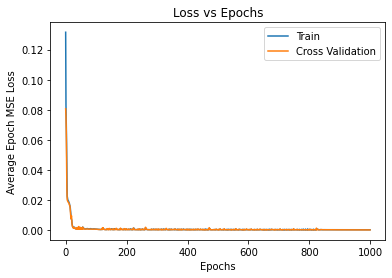

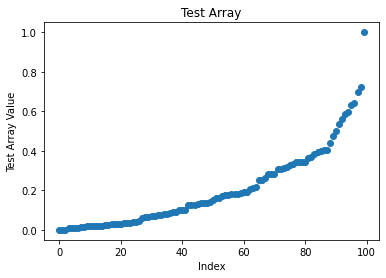

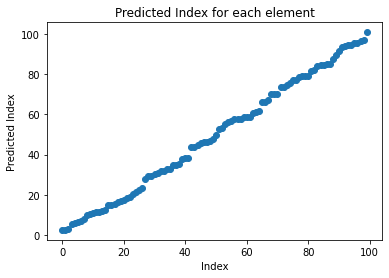

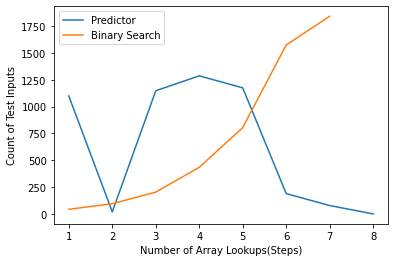

Average Number of Steps
Through Predictor:3.4616
Through Binary Search:5.7902


In [15]:
net_2=Net_2HL()
net_2.to('cuda')

train_input,train_ans=generate_dataset(training_examples,n,_type='exponential')
cv_input,cv_ans=generate_dataset(cv_examples,n,_type='exponential')
train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=1000)
test_single_array(net_2,n,'exponential')

np.random.seed(42)
test_input,test_ans=generate_dataset(testing_examples,n,_type='exponential')
out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)

#Mixed

 52%|█████▏    | 26/50 [00:00<00:00, 126.47it/s]

0.13120030760765075
0.08250770941376687
0.06602679714560508
0.0556783739477396
0.04693533778190613
0.04030211418867111
0.03482486121356487
0.030165156163275243
0.026295473240315913
0.023040208965539932
0.020385815016925334
0.018221190385520458
0.016491408087313177
0.015116346534341574
0.014040520507842302
0.01320585710927844
0.012564207054674625
0.012075895629823207
0.011706722341477871
0.011428896803408861
0.011220449674874544
0.011064115911722183
0.01094653746113181
0.010857586562633515
0.010789687093347312
0.010737164504826069


100%|██████████| 50/50 [00:00<00:00, 124.62it/s]


0.01069566747173667
0.01066167103126645
0.01063219215720892
0.010604813694953918
0.01057801404967904
0.010551435127854347
0.010525759309530258
0.010502288676798343
0.01048233425244689
0.010466171335428954
0.010452601313591003
0.010440219938755036
0.010428633634001016
0.010418076999485493
0.010408538766205311
0.01039979448541999
0.010391775332391263
0.01038444396108389
0.01037772260606289
0.010371565353125334
0.010365922283381224
0.010360753629356623
0.010356021579355001
0.010351692512631416


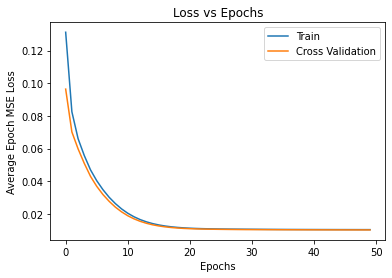

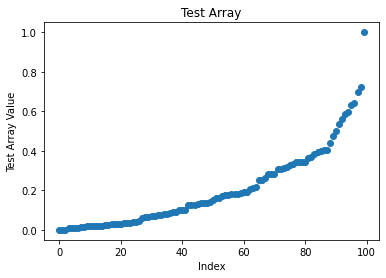

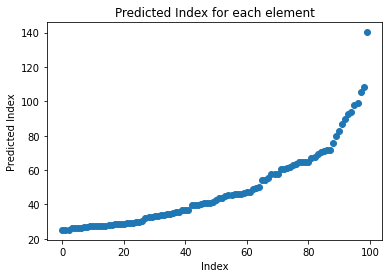

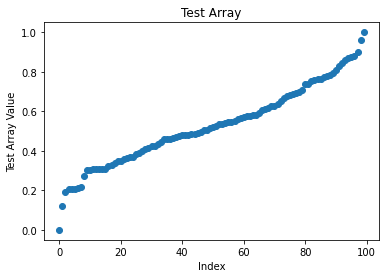

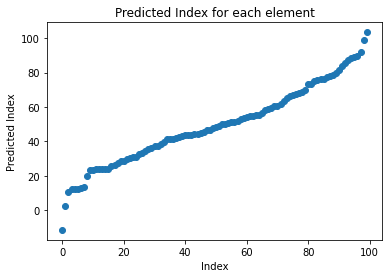

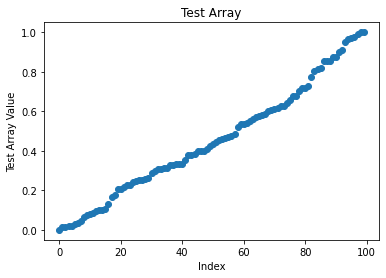

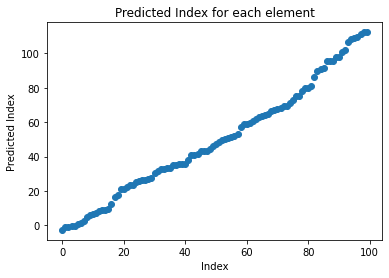

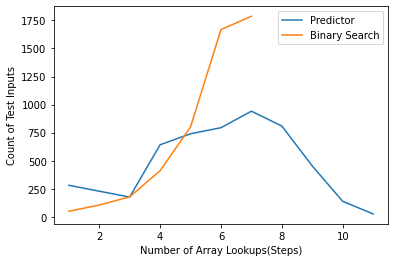

Average Number of Steps
Through Predictor:6.1286
Through Binary Search:5.792


In [16]:
net=Net_NHL()
net.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net,n,'exponential')
test_single_array(net,n,'normal')
test_single_array(net,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)




 30%|███       | 15/50 [00:00<00:00, 70.68it/s]

0.16320747062563895
0.09958640411496163
0.08312086015939713
0.07308485358953476
0.06200846843421459
0.050045983493328096
0.0367461659014225
0.024480016343295573
0.015383219160139561
0.011095767375081778
0.010047158785164356
0.009612182434648276
0.009187558945268393
0.008844716195017099
0.008533309772610664


 46%|████▌     | 23/50 [00:00<00:00, 70.91it/s]

0.008264745865017176
0.008083260804414748
0.007912736805155873
0.007733289385214448
0.007562289852648974
0.007401877222582698
0.007173859933391214
0.0069352058228105305
0.006746321311220526
0.006581831444054842
0.006420436780899763
0.006271858513355255
0.006135390233248472
0.00601443387567997
0.005894494522362947


 78%|███████▊  | 39/50 [00:00<00:00, 71.21it/s]

0.0057567684445530174
0.0056111321318894625
0.005484551936388016
0.005302743380889296
0.00502058076672256
0.004841531254351139
0.004732487024739385
0.004632602306082844
0.004707615496590734
0.004791084490716457
0.0044151844922453165
0.004259469034150243
0.004849701654165983
0.004259337717667222
0.004123893612995744


100%|██████████| 50/50 [00:00<00:00, 70.47it/s]


0.004305674973875284
0.004030088055878877
0.004133010655641556
0.00450602665077895
0.004498982266522944


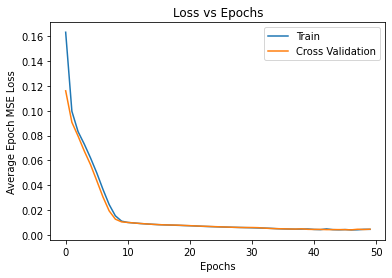

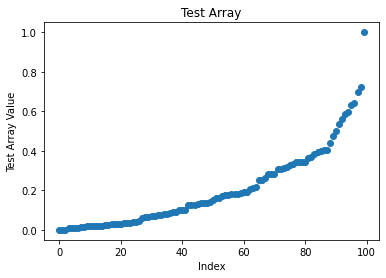

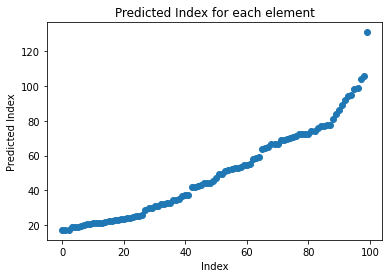

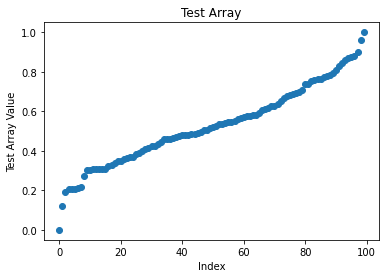

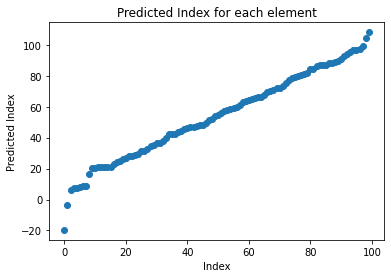

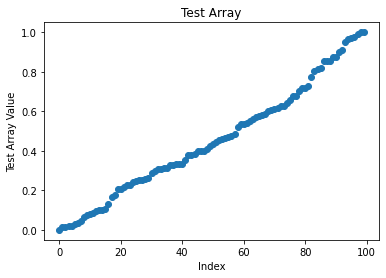

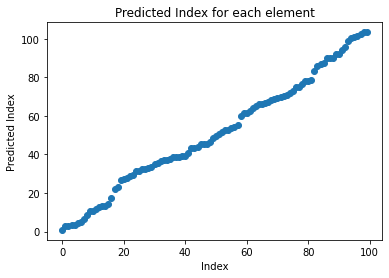

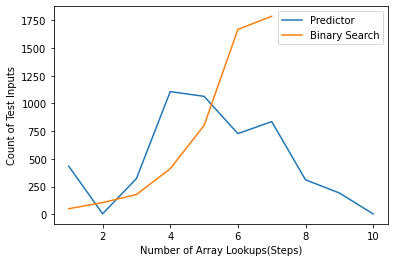

Average Number of Steps
Through Predictor:5.1242
Through Binary Search:5.792


In [17]:
net_1=Net_1HL()
net_1.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net_1,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_1,n,'exponential')
test_single_array(net_1,n,'normal')
test_single_array(net_1,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net_1,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)


 12%|█▏        | 6/50 [00:00<00:00, 54.47it/s]

0.13051472827792168
0.08912968933582306
0.08132426515221595
0.07466801255941391
0.06483389623463154
0.04632162563502788
0.022243136819452048
0.02487848810851574
0.016000645235180855
0.01143869049847126
0.010245128069072962


 36%|███▌      | 18/50 [00:00<00:00, 54.09it/s]

0.009236933290958404
0.008832431677728892
0.008529375866055488
0.008220487600192427
0.007983837695792317
0.007769734365865588
0.007557985093444586
0.007353855157271027
0.007121366914361715
0.006890700338408351
0.006656351871788502
0.006416508881375194


 60%|██████    | 30/50 [00:00<00:00, 54.58it/s]

0.006154996249824763
0.005870415410026908
0.0055880600586533545
0.005322560854256153
0.005046938452869654
0.004795799357816577
0.004549700301140547
0.004322637058794499
0.004134390107356012
0.00396712408401072
0.003818982467055321
0.0036908691050484776


 84%|████████▍ | 42/50 [00:00<00:00, 54.67it/s]

0.003582936921156943
0.0034934065071865915
0.0034211577614769338
0.003353554452769458
0.003184075839817524
0.0029754083137959243
0.0028727284166961907
0.0027918824926018715
0.0028198020067065955
0.0027903291396796704
0.0029431227128952743


100%|██████████| 50/50 [00:00<00:00, 53.76it/s]


0.0026102879317477347
0.002999351732432842
0.002296288521029055
0.002614766568876803


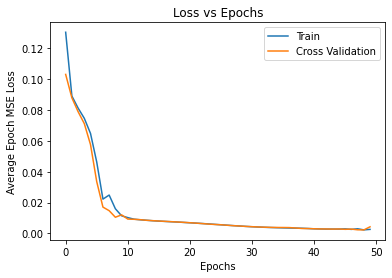

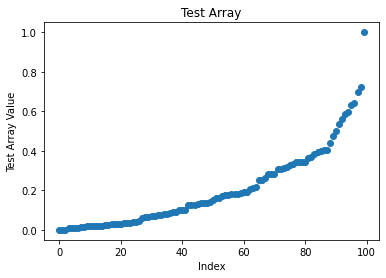

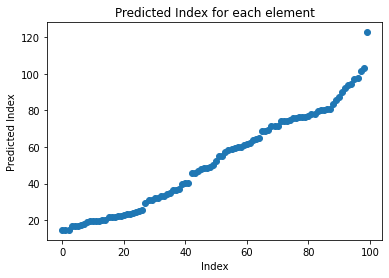

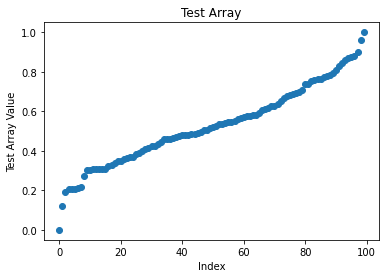

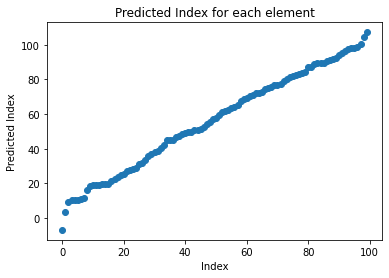

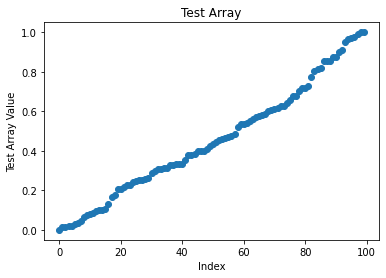

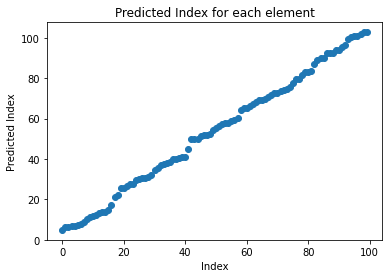

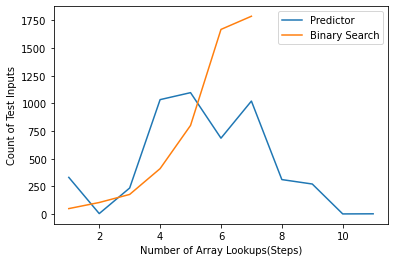

Average Number of Steps
Through Predictor:5.3862
Through Binary Search:5.792


In [18]:
net_2=Net_2HL()
net_2.to('cuda')

train_unif,train_ans1=generate_dataset(17000,n,_type='uniform')
cv_unif,cv_ans1=generate_dataset(1700,n,_type='uniform')

train_normal,train_ans2=generate_dataset(17000,n,_type='normal')
cv_normal,cv_ans2=generate_dataset(1700,n,_type='normal')

train_exponential,train_ans3=generate_dataset(16000,n,_type='exponential')
cv_exponential,cv_ans3=generate_dataset(1600,n,_type='exponential')

train_input=torch.cat((train_unif,train_normal,train_exponential))
train_ans=torch.cat((train_ans1,train_ans2,train_ans3))
cv_input=torch.cat((cv_unif,cv_normal,cv_exponential))
cv_ans=torch.cat((cv_ans1,cv_ans2,cv_ans3))

shuffled_idx=torch.randperm(train_input.shape[0])
train_input=train_input[shuffled_idx]
train_ans=train_ans[shuffled_idx]

shuffled_idx1=torch.randperm(cv_input.shape[0])
cv_input=cv_input[shuffled_idx1]
cv_ans=cv_ans[shuffled_idx1]

train_dataset(net_2,train_input,train_ans,cv_input,cv_ans,training_examples,epochs=50)
test_single_array(net_2,n,'exponential')
test_single_array(net_2,n,'normal')
test_single_array(net_2,n,'uniform')

np.random.seed(42)
test_unif,test_ans1=generate_dataset(1700,n,_type='uniform')
test_normal,test_ans2=generate_dataset(1700,n,_type='normal')
test_exponential,test_ans3=generate_dataset(1600,n,_type='exponential')

test_input=torch.cat((test_unif,test_normal,test_exponential))

shuffled_idx=torch.randperm(test_input.shape[0])
test_input=test_input[shuffled_idx]

out=predict(net_2,test_input,n)
predictions_cnt,bs_cnt=get_predictions(test_input,n,testing_examples,out)
d1,d2=generate_plots(predictions_cnt,bs_cnt)
average_steps(d1,d2)
